In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
from torch.utils.data import DataLoader ,Dataset
import numpy as np 
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim






In [41]:
# Load your data
X = pd.read_csv("../Data/Clean.csv", sep=",") # This should be the matrix of microbiome data
#X= pd.DataFrame(X)
y = X[["Sample", "Case"]] # This should be the binary variable indicating healthy/diseased
X.drop(X[["Sample", "Case"]], axis=1, inplace=True)
X = X.applymap(lambda x: 1 if x == 'Healthy' else x)






In [42]:
# Extract the feature columns and label column
features = X.values
label = y['Case']


# Convert each element of the array to a float
features = features.astype(float)

# Convert the labels to numerical values
label_dict = {'Healthy': 1, 'Diseased': 0}
label_n = [label_dict[label] for label in label]

# Convert the feature columns to a PyTorch tensor
features_tensor = torch.tensor(features)

# Convert the label column to a PyTorch tensor
label_tensor = torch.tensor(label_n)

# Create a TensorDataset from the feature and label tensors
dataset = torch.utils.data.TensorDataset(features_tensor, label_tensor)

#Save it to tensor .pt objects
torch.save(label_tensor, '../Data/labels.pt')
torch.save(features_tensor, '../Data/features.pt')



In [111]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        
        # Decoder
        self.fc3 = nn.Linear(z_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h1 = nn.functional.relu(self.fc1(x))
        mu, logvar = self.fc21(h1), self.fc22(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = nn.functional.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [75]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 725), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [89]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [122]:
def train_vae1(model, eex, epochs, batch_size, learning_rate):
    train_loader =  DataLoader(dataset, batch_size=20, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch_idx, eex in enumerate(train_loader):
           
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data.float())
            loss = loss_function(recon_batch, data.float(), mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
        print('Epoch: {} \t Loss: {:.6f}'.format(epoch+1, train_loss / len(train_loader.dataset)))

In [106]:
input_dim = 725 # Define the size of your input data
hidden_dim = 50 # Define the size of your hidden layer
z_dim = 2 # Define the size of the latent space
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(input_dim,hidden_dim,z_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50

In [120]:
# Load the microbiome data and labels into PyTorch tensors
data = torch.load("../Data/features.pt")
labels = torch.load("../Data/labels.pt")
dataset = torch.utils.data.TensorDataset(data, labels)
# Define the dataset and dataloader
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

In [123]:
train_vae1(model, dataloader, 100, 32, 1e-3)

/Users/stef_cm/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	 Loss: 18455.839224
Epoch: 2 	 Loss: 8626.699974
Epoch: 3 	 Loss: 5059.020087
Epoch: 4 	 Loss: 3585.809138
Epoch: 5 	 Loss: 2837.478190
Epoch: 6 	 Loss: 2429.490412
Epoch: 7 	 Loss: 2128.727170
Epoch: 8 	 Loss: 1879.071800
Epoch: 9 	 Loss: 1662.425755
Epoch: 10 	 Loss: 1479.747275
Epoch: 11 	 Loss: 1329.419154
Epoch: 12 	 Loss: 1204.786724
Epoch: 13 	 Loss: 1104.096273
Epoch: 14 	 Loss: 1021.805257
Epoch: 15 	 Loss: 954.958305
Epoch: 16 	 Loss: 898.757647
Epoch: 17 	 Loss: 851.285046
Epoch: 18 	 Loss: 810.313743
Epoch: 19 	 Loss: 775.916815
Epoch: 20 	 Loss: 746.068598
Epoch: 21 	 Loss: 720.487113
Epoch: 22 	 Loss: 696.564761
Epoch: 23 	 Loss: 675.610906
Epoch: 24 	 Loss: 656.686907
Epoch: 25 	 Loss: 640.749372
Epoch: 26 	 Loss: 625.188887
Epoch: 27 	 Loss: 610.887247
Epoch: 28 	 Loss: 597.994559
Epoch: 29 	 Loss: 587.220296
Epoch: 30 	 Loss: 576.742004
Epoch: 31 	 Loss: 566.581736
Epoch: 32 	 Loss: 557.319831
Epoch: 33 	 Loss: 548.505598
Epoch: 34 	 Loss: 540.661919
Epoch: 3

In [124]:
torch.save(VAE.state_dict(model), '../Model/vae.pth')

In [140]:
#load Model and encode data
VAE.load_state_dict(model, torch.load('vae.pth'))


<All keys matched successfully>

In [181]:
with torch.no_grad():
    z, _ = model.encode(features_tensor.float())

In [182]:
z

tensor([[-2.1912, -0.6466],
        [-2.2201, -0.6218],
        [-2.1728, -0.6568],
        ...,
        [ 0.7815,  1.3235],
        [ 0.7794,  1.3244],
        [ 0.7759,  1.3235]])

In [129]:
# Import dataset and classes needed in this example:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from itertools import product

# Import Gaussian Naive Bayes classifier:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [130]:
#Flatten:
shape = z.shape
tensor_reshaped = z.reshape(shape[0],-1)
#Drop all rows containing any nan:
tensor_reshaped = tensor_reshaped[~torch.any(tensor_reshaped.isnan(),dim=1)]
#Reshape back:
tensor = tensor_reshaped.reshape(tensor_reshaped.shape[0],*shape[1:])

In [187]:
# Split dataset into random train and test subsets:
train, test, train_labels, test_labels = train_test_split(z, labels, test_size=0.5, random_state=11)

# Initialize classifier:
gnb = GaussianNB()

# Train the classifier:
classifier = gnb.fit(train, train_labels)
# Make predictions with the classifier:
predictive_labels = gnb.predict(test)
print(predictive_labels)

# Evaluate label (subsets) accuracy:
print(accuracy_score(test_labels, predictive_labels))

[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0
 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1
 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0
 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1
 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 1 1 0 0 0 0]
0.75664

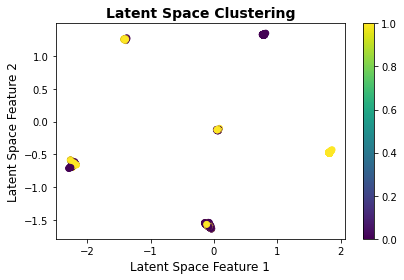

In [188]:
# assume you have X as your latent space data and y as your labels
gnb = GaussianNB()
y_pred = gnb.fit(z, labels).predict(z)

plt.scatter(z[:, 0], z[:, 1], c=labels)
plt.title('Latent Space Clustering', fontsize=14, fontweight='bold')
plt.xlabel('Latent Space Feature 1', fontsize=12)
plt.ylabel('Latent Space Feature 2', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.colorbar()
plt.tight_layout()
plt.show()


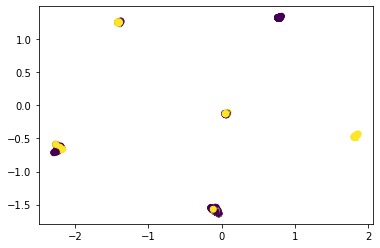

In [185]:
plt.scatter(z[:, 0], z[:, 1],c=labels)

In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [175]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(z, labels)

LogisticRegression(max_iter=1000, random_state=42)

In [186]:
# Evaluate the classifier on the validation set
y_val_pred = clf.predict(test)
val_accuracy = accuracy_score(test_labels, y_val_pred)
val_confusion_matrix = confusion_matrix(test_labels, y_val_pred)

In [178]:
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation confusion matrix:\n{val_confusion_matrix}")

Validation accuracy: 0.5930
Validation confusion matrix:
[[290   0]
 [199   0]]


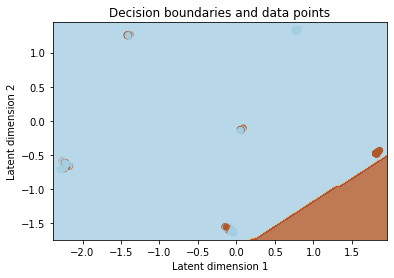

In [179]:
# Plot the decision boundaries and data points
x_min, x_max = test[:, 0].min() - 0.1, test[:, 0].max() + 0.1
y_min, y_max = test[:, 1].min() - 0.1, test[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(test[:, 0], test[:, 1], c=test_labels, cmap=plt.cm.Paired)
plt.title('Decision boundaries and data points')
plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.show()